In [80]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
from pathlib import Path
import pandas as pd
import einops
from sklearn.metrics.pairwise import cosine_distances
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


### Loading Data:

In [3]:
video_path = "/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/multicam_video_2024-07-22T10_19_22_cropped_20250325101012/multicam_video_2024-07-22T10_19_22_mirror-bottom.avi.mp4"

In [4]:
# now we load the video as frames
cap = cv2.VideoCapture(video_path)

# === Step 2: Initialize list to store frames ===
frames = []

# === Step 3: Read the video frame-by-frame ===
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # For grayscale
    frames.append(frame)

# === Step 4: Convert list to NumPy array ===
video_array = np.array(frames)  # Shape: (num_frames, height, width, channels)

# === Step 5: Cleanup ===
cap.release()

### Method 1: Frame Difference-Based Keyframe Selection

Key frames are frames that represent transitons or new visual content in a video sequence. Thus, we are going to try to select frames where the pixel-level difference is the greatest

We have decided to use a Histogram Difference (statistical change) that uses the comparison between distribution of pixel intensities:

1. Convert img to hist
2. compute hist diff: like L1 or cos sim
3. Select the top-k frames with the highest score

In [23]:
# we know compute the hist 
def compute_histograms(frames: np.ndarray, bins: int = 64) -> np.ndarray:
    n_frames = frames.shape[0]
    
    flat_vid = einops.rearrange(frames, 'frame h w -> frame (h w)')

    histograms = []
    for i in tqdm(range(n_frames), desc='Compute pixel distribution'):
        hist, _ = np.histogram(flat_vid[i], bins=bins, range=(0, 255), density=True)
        histograms.append(hist)

    histograms = np.stack(histograms)  # shape: (n_frames, bins)
    assert histograms.shape == (n_frames, bins)
    return histograms

In [24]:
hist = compute_histograms(video_array)

Compute pixel distribution: 100%|██████████| 35961/35961 [00:25<00:00, 1428.48it/s]


In [26]:
# compute the diff 
def compute_cosine_diff(histograms: np.ndarray) -> np.ndarray:
    # Normalize the histograms first (L2 norm)
    norms = np.linalg.norm(histograms, axis=1, keepdims=True)
    hist_norm = histograms / (norms + 1e-8)  # prevent divide by 0

    # Shift histograms to compare frame t and t-1
    h1 = hist_norm[1:]       # t = 1 to N-1
    h0 = hist_norm[:-1]      # t = 0 to N-2

    # Cosine similarity = dot product of normalized vectors
    sim = np.sum(h1 * h0, axis=1)  # shape: (n_frames - 1,)
    diff = 1 - sim  # cosine distance (1 = completely different)

    return diff  # shape: (n_frames - 1,)

In [27]:
cos_sim = compute_cosine_diff(hist)

In [33]:
def select_keyframes(differences:np.ndarray, k:int = 30):
    idx = np.argsort(differences)[-k:]
    return np.sort(idx+1)

In [34]:
idx = select_keyframes(cos_sim)
keyframes = video_array[idx, ...]

### Method 2: Features and K-mean clustering

We first extract features from our frames using a pre trained convolutional network: we obtain a vector with extracted features, then we cluster in the feature space (K-means)

In [65]:
import torch 
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.cluster import KMeans
import torchvision.transforms as T
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA

In [7]:
device = "mps"
torch.device(device)

device(type='mps')

In [9]:
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()
model = resnet50(weights= weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/thomasbush/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:17<00:00, 5.73MB/s]


In [54]:
# we remove the last layer, don't need it
model = torch.nn.Sequential(*list(model.children())[:-1]).to(device)  # chop off the last FC layer

model.eval()  # important!

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [30]:
preprocess_custom = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),  # OR use T.Resize with aspect ratio preservation + padding
    T.Normalize(mean=[0.485, 0.456, 0.406],  
                std=[0.229, 0.224, 0.225])
])

In [44]:
# now we extract the feautues:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, frame_array, transform=None, target_transform=None):
        self.frames = frame_array
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.frames.shape[0]
    
    def __getitem__(self, idx):
        img = self.frames[idx]  # shape: [H, W]
        
        # Convert grayscale -> RGB by repeating across 3 channels
        img_rgb = np.stack([img] * 3, axis=-1)  # shape: [H, W, 3]
        
        img_pil = Image.fromarray(img_rgb.astype(np.uint8))
        
        if self.transform:
            img = self.transform(img_pil)
        return img

In [45]:
img_dataset = CustomDataset(video_array, transform=preprocess)

In [46]:
batch_size = 64
data_loader = DataLoader(img_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# produce the features:
features = []
with torch.no_grad():
    for img in tqdm(data_loader, desc=f'Extracting features '):
        img = img.to(device)
        features.append(model.forward(img))


In [57]:
features = [img.to('cpu') for img in features]
f = np.concatenate(features)

In [60]:
features_np = f.mean(axis=(2, 3)) 

In [62]:
pca = PCA(n_components = .9)
features_pca = pca.fit_transform(features_np)

In [66]:
kmeans = KMeans(n_clusters=30, random_state=42)
kmeans.fit(features_pca)

closest_indices, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, features_pca)
keyframe_indices = sorted(closest_indices)

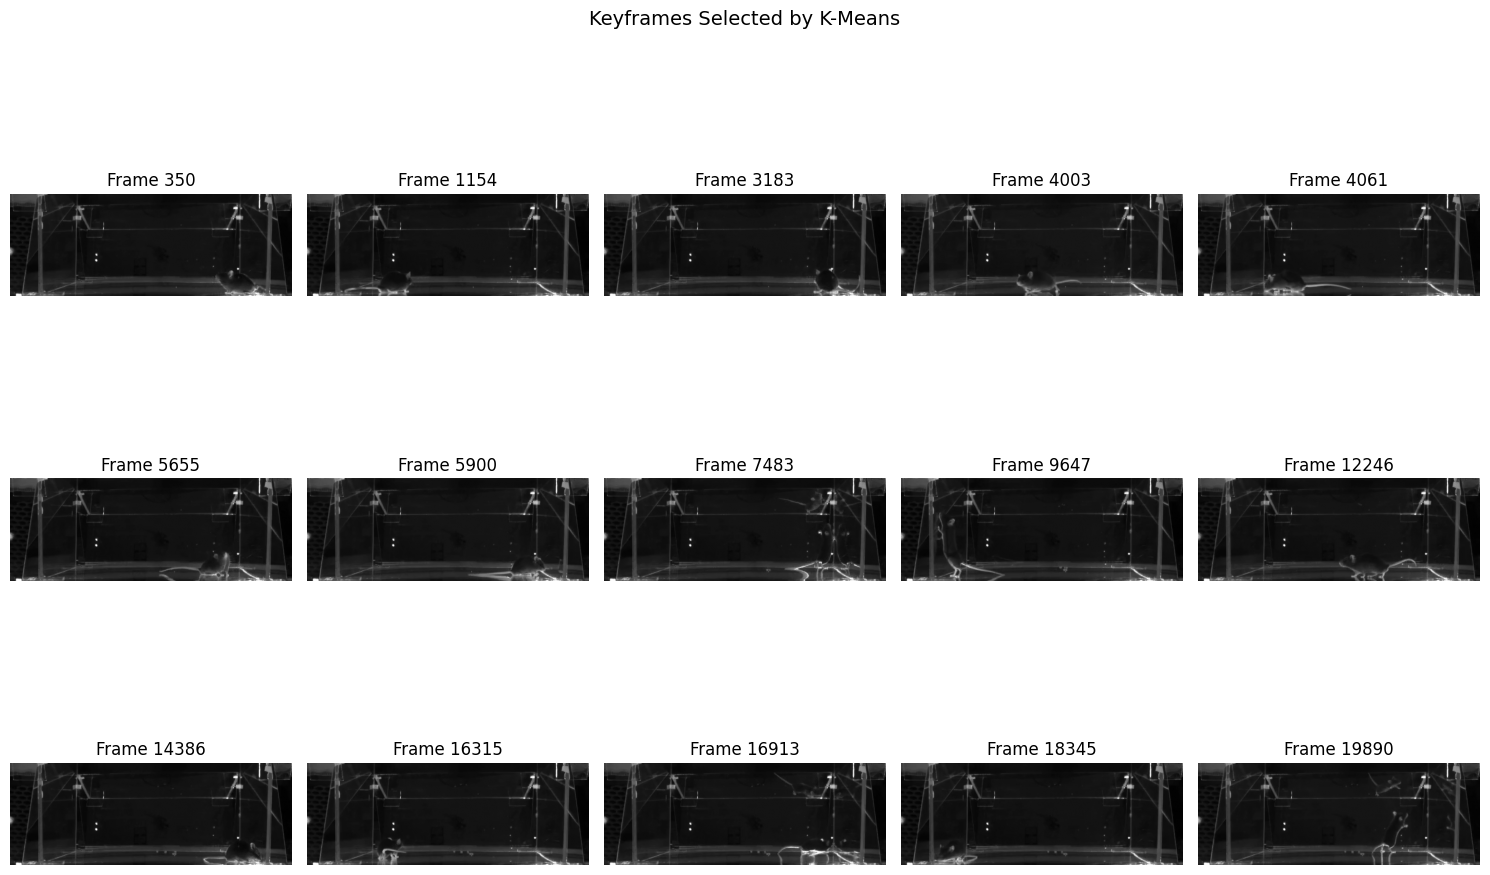

In [87]:
# display some of the keyframes
n_rows, n_cols = 3, 5  # 3x5 grid to show 15 frames
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axs = axs.flatten()

# Display up to 15 keyframes
for i, ax in enumerate(axs):
    if i < len(keyframe_indices):
        ax.imshow(video_array[keyframe_indices[i]], cmap='gray')
        ax.set_title(f'Frame {keyframe_indices[i]}')
    ax.axis('off')  # Hide axes

plt.tight_layout()
fig.suptitle("Keyframes Selected by K-Means", y=1.02, fontsize=14)
plt.show()

### Method 3: Perceptual Hashing

It generates a compact signature of an image based on its visual structure. The algorithm does:
1. resize
2. compute mena pixel intensity 
3. if p>m-> 1 else 0
4. flatten the binary matrix inot a 1D bit string (for img= 8x8 -> 64 flatten)
5. compares two hashes using Hamming distance=The Hamming distance between two equal-length strings of symbols is the number of positions at which the corresponding symbols are different

In [72]:
dsize = (16, 16)
resized_frames = []

for frame in tqdm(video_array):
    resized = cv2.resize(frame, dsize=dsize, interpolation=cv2.INTER_LINEAR)
    resized_frames.append(resized)

resized_array = np.stack(resized_frames)

100%|██████████| 35961/35961 [00:15<00:00, 2326.72it/s]


In [74]:
# we compute the mean intensity 
m = resized_array.mean(axis=(0,))
# set to 1 if p > m else 0
binary_img = np.where(resized_array>m, 1, 0)

In [76]:
# we flatten our array:
flatten_hashes = einops.rearrange(binary_img, 'f h w -> f (h w)')